**Import Liblary Yang di gunakan**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack
from sklearn.metrics import average_precision_score
import numpy as np
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dot
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from keras.losses import Huber

**Lakukan Data Loading**

In [4]:

customers_df = pd.read_csv('olist_customers_dataset.csv')
order_reviews_df = pd.read_csv('olist_order_reviews_dataset.csv')
orders_df = pd.read_csv('olist_orders_dataset.csv')
products_df = pd.read_csv('olist_products_dataset.csv')
order_items_df = pd.read_csv('olist_order_items_dataset.csv')

Melihat Sampel 5 data dari customers_df

In [ ]:
print("Customers DataFrame")
customers_df.head()

Customers DataFrame


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


**Variabel Pada Customers_df**

customer_id: digunakan untuk mencatat transaksi atau interaksi pelanggan dalam platform tertentu bersifat unik untuk setiap Transaksi satu id menadakan 1 transaksi,

customer_unique_id: digunakan untuk mendapatkan informasi pelanggan yang konsisten dari berbagai platform yang berbeda bersifat unik 1 id  menadakan 1 user .

customer_zip_code_prefix: Ini adalah kode pos atau awalan kode pos pelanggan. Biasanya, kode pos ini digunakan untuk mengidentifikasi area geografis atau lokasi pelanggan. Awalan kode pos ini bisa merujuk pada wilayah atau kota tertentu.

customer_city: Ini adalah nama kota tempat pelanggan berada. Misalnya, dalam data ini ada kota-kota seperti "franca", "sao bernardo do campo", dan lainnya.

customer_state: Ini adalah nama negara bagian atau provinsi tempat pelanggan berada. Pada dataset ini, semuanya berada di negara bagian SP (São Paulo) di Brasil.


**Melihat Tipe data serta adakah yang Null dalam data**

In [ ]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


**Melkaukan Pengecekan apakah benar data id user dan unik id  benar benar unik**

In [ ]:
count_all_unik_id = customers_df['customer_unique_id'].count()
print('count_all_unik_id : ',str(count_all_unik_id))

count_all_id = customers_df['customer_id'].count()
print('count_all_id : ',str(count_all_id))

count_all_unik_id :  99441
count_all_id :  99441


**Memastikan Kembali Apakah ada data yang hilang**

In [ ]:
missing_values = customers_df.isna().sum()

missing_values

,0
customer_id,0
customer_unique_id,0
customer_zip_code_prefix,0
customer_city,0
customer_state,0


**Menghapus Fitur Yang Tidak Di perlukan untuk sebuah rekomendasi diantara nya custemer state,customer_zip_code_prefix**

In [ ]:
customers_df = customers_df.drop(columns=['customer_state', 'customer_zip_code_prefix'])
customers_df.head()

,customer_id,customer_unique_id,customer_city
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,sao bernardo do campo
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,sao paulo
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,mogi das cruzes
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,campinas


**melihat sampel data pada orders_df**

In [ ]:
orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


Melihat informasi data awal,seperti jumlah baris,kolom dan jumlah nan

In [5]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


Berikut adalah penjelasan variabel-variabel:

1. **order_id**: Merupakan ID unik yang mengidentifikasi setiap pesanan yang dilakukan oleh pelanggan.
   
2. **customer_id**: Merupakan ID unik yang mengidentifikasi setiap pelanggan yang melakukan pembelian.

3. **order_status**: Status dari pesanan, misalnya "delivered" menunjukkan bahwa pesanan telah berhasil dikirimkan kepada pelanggan.

4. **order_purchase_timestamp**: Waktu dan tanggal ketika pesanan dibuat oleh pelanggan.

5. **order_approved_at**: Waktu dan tanggal ketika pesanan disetujui oleh sistem atau pihak yang berwenang (misalnya sistem pembayaran atau verifikasi).

6. **order_delivered_carrier_date**: Tanggal dan waktu ketika pesanan diserahkan kepada pihak pengiriman atau kurir.

7. **order_delivered_customer_date**: Tanggal dan waktu ketika pesanan diterima oleh pelanggan setelah proses pengiriman.

8. **order_estimated_delivery_date**: Tanggal perkiraan kapan pesanan akan sampai ke pelanggan (dalam banyak kasus, ini adalah estimasi pengiriman yang disediakan oleh sistem atau kurir).

Data ini memberikan informasi yang mendetail mengenai timeline pesanan mulai dari pembelian hingga penerimaan barang oleh pelanggan.

**Memasikan coustumer_id tidak ada duplikat karena fitur ini akan selalu bernilai unik karena di buat di setiap transaksi**

In [ ]:
customer_counts = orders_df['customer_id'].value_counts()

# Ambil hanya customer_id yang muncul lebih dari sekali
duplicates = customer_counts[customer_counts > 1]

print(duplicates)

Series([], Name: count, dtype: int64)


**Mengahpus kolom yang tidak berperan dalam sistem rekomendasi**

In [ ]:
orders_df.drop(columns=[
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
], inplace=True)


**Memastikan kembali setiap fitur sudah sesuai dan melihat apakah ada yang kosong**

In [ ]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   order_id      99441 non-null  object
 1   customer_id   99441 non-null  object
 2   order_status  99441 non-null  object
dtypes: object(3)
memory usage: 2.3+ MB


**melihat sampel pada dataframe order_reviews**

In [ ]:

print("\nOrder Reviews DataFrame")
order_reviews_df.head()


Order Reviews DataFrame


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


Melihat informasi data awal,seperti jumlah baris,kolom dan jumlah nan

In [6]:
order_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


Berikut adalah penjelasan variabel-variabel:

1. **review_id**: ID unik yang mengidentifikasi setiap ulasan yang diberikan oleh pelanggan.

2. **order_id**: ID pesanan yang terkait dengan ulasan tersebut. Ini menghubungkan ulasan dengan pesanan yang dibeli.

3. **review_score**: Skor yang diberikan oleh pelanggan untuk produk yang dibeli. Skor ini biasanya dalam bentuk angka, misalnya dari 1 hingga 5, untuk menunjukkan tingkat kepuasan pelanggan terhadap produk.

4. **review_comment_title**: Judul dari ulasan yang diberikan. Biasanya ini adalah ringkasan atau headline yang menggambarkan pendapat umum pelanggan tentang produk.

5. **review_comment_message**: Pesan atau deskripsi lengkap dari ulasan yang diberikan oleh pelanggan. Bagian ini memberikan detail lebih lanjut tentang pengalaman mereka dengan produk.

6. **review_creation_date**: Tanggal dan waktu saat ulasan dibuat oleh pelanggan. Ini memberi informasi kapan pelanggan memberikan feedback terhadap produk.

7. **review_answer_timestamp**: Tanggal dan waktu ketika ulasan dijawab oleh pihak penjual atau sistem. Ini menunjukkan kapan ulasan tersebut mendapatkan respons (jika ada).


Menghapus_kolom yang tidak perlu

In [ ]:
order_reviews_df.drop(columns=['review_comment_title','review_comment_message','review_creation_date','review_answer_timestamp'],inplace=True)

**Kembali Menglihat sampel data setelah pemilahan fitur**

In [ ]:
order_reviews_df.head()

,review_id,order_id,review_score
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5


**Melihat apakah ada yang null atau tidak dalam data frame order_reviews**

In [ ]:
order_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   review_id     99224 non-null  object
 1   order_id      99224 non-null  object
 2   review_score  99224 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.3+ MB


**Visualisasi sebaran data Review Score Dan melihat rarat score secara umum**

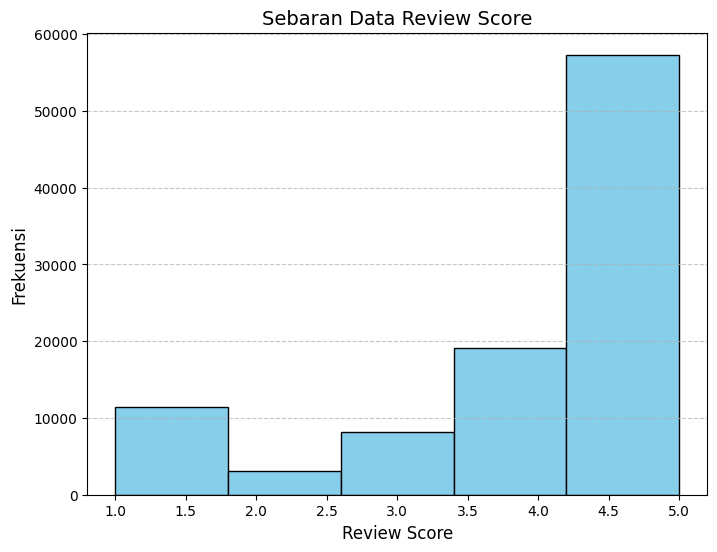

Proporsi pengguna yang memberikan rating maksimal (5): 57.78%
Rata-rata review score secara umum: 4.09


In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(order_reviews_df['review_score'], bins=5, color='skyblue', edgecolor='black')
plt.title('Sebaran Data Review Score', fontsize=14)
plt.xlabel('Review Score', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 2. Proporsi Pengguna Memberikan Rating Maksimal
total_reviews = len(order_reviews_df)
max_rating_count = len(order_reviews_df[order_reviews_df['review_score'] == 5])
max_rating_proportion = (max_rating_count / total_reviews) * 100

# 3. Rata-rata Review Score Secara Umum
avg_review_score = order_reviews_df['review_score'].mean()

print(f"Proporsi pengguna yang memberikan rating maksimal (5): {max_rating_proportion:.2f}%")
print(f"Rata-rata review score secara umum: {avg_review_score:.2f}")

**melihat_sampel data dari order_items_df**

In [ ]:

print("\norder_items_df")
order_items_df.head(n=10)


order_items_df


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
5,00048cc3ae777c65dbb7d2a0634bc1ea,1,ef92defde845ab8450f9d70c526ef70f,6426d21aca402a131fc0a5d0960a3c90,2017-05-23 03:55:27,21.90,12.69
6,00054e8431b9d7675808bcb819fb4a32,1,8d4f2bb7e93e6710a28f34fa83ee7d28,7040e82f899a04d1b434b795a43b4617,2017-12-14 12:10:31,19.90,11.85
7,000576fe39319847cbb9d288c5617fa6,1,557d850972a7d6f792fd18ae1400d9b6,5996cddab893a4652a15592fb58ab8db,2018-07-10 12:30:45,810.00,70.75
8,0005a1a1728c9d785b8e2b08b904576c,1,310ae3c140ff94b03219ad0adc3c778f,a416b6a846a11724393025641d4edd5e,2018-03-26 18:31:29,145.95,11.65
9,0005f50442cb953dcd1d21e1fb923495,1,4535b0e1091c278dfd193e5a1d63b39f,ba143b05f0110f0dc71ad71b4466ce92,2018-07-06 14:10:56,53.99,11.40


Melihat informasi data awal,seperti jumlah baris,kolom dan jumlah nan

In [7]:
order_items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


Berikut adalah penjelasan untuk setiap variabel yang terdapat dalam data ini:

1. **order_id**: ID unik yang mengidentifikasi pesanan. Ini menghubungkan item yang dibeli dalam satu transaksi atau pesanan.

2. **order_item_id**: ID unik untuk setiap item dalam pesanan. Dalam satu pesanan bisa ada lebih dari satu item, dan ID ini mengidentifikasi item spesifik.

3. **product_id**: ID unik yang mengidentifikasi produk yang dibeli. Ini merujuk pada produk spesifik yang dipesan dalam transaksi tersebut.

4. **seller_id**: ID unik yang mengidentifikasi penjual produk tersebut. Setiap penjual memiliki ID yang berbeda untuk membedakan mereka dalam sistem.

5. **shipping_limit_date**: Tanggal dan waktu batas akhir untuk pengiriman produk, yang menunjukkan kapan penjual harus mengirimkan barang tersebut kepada pelanggan.

6. **price**: Harga produk yang dibeli, biasanya dalam mata uang tertentu. Ini adalah biaya dasar produk tanpa mempertimbangkan biaya pengiriman.

7. **freight_value**: Biaya pengiriman yang dikenakan untuk produk tersebut. Ini adalah biaya tambahan untuk pengiriman barang kepada pelanggan, yang dapat bervariasi berdasarkan lokasi pengiriman, berat produk, dan lainnya.



**menghapus kolom yang tidak di pelukan**

In [ ]:
order_items_df.drop(columns=['seller_id','shipping_limit_date'],inplace=True)


In [ ]:
order_items_df['total_value'] = order_items_df['price'] + order_items_df['freight_value']

**Membuat kolom baru total_value hasil penjumlahan dari kolom price dan kolom freight_value**

**Melihat tipe data dan adakah data yang null**

In [ ]:
order_items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   order_id       112650 non-null  object 
 1   order_item_id  112650 non-null  int64  
 2   product_id     112650 non-null  object 
 3   price          112650 non-null  float64
 4   freight_value  112650 non-null  float64
 5   total_value    112650 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 5.2+ MB


**Melihat sampel data dari order_items**

In [ ]:
order_items_df.head()

,order_id,order_item_id,product_id,price,freight_value,total_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,58.90,13.29,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,239.90,19.93,259.83
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,199.00,17.87,216.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,12.99,12.79,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,199.90,18.14,218.04


**Melihat top 5  produks bedasrkan total_value dan freight_value**

In [ ]:

top_5_freight_value = order_items_df.groupby('product_id')['freight_value'].sum().nlargest(5)

# 3. Top 5 produk berdasarkan total_value
top_5_total_value = order_items_df.groupby('product_id')['total_value'].sum().nlargest(5)





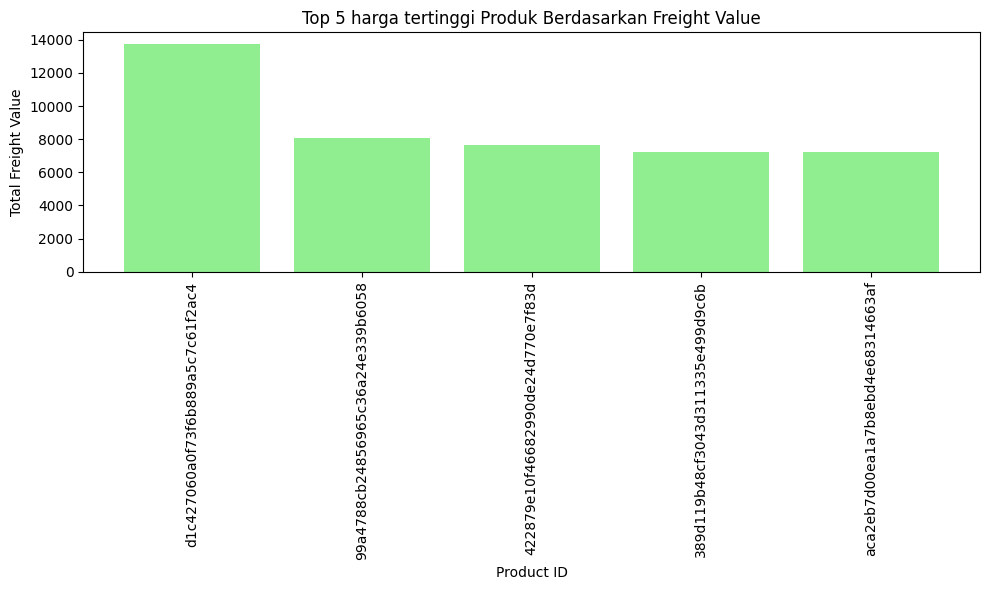

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(top_5_freight_value.index, top_5_freight_value.values, color='lightgreen')
plt.title('Top 5 harga tertinggi Produk Berdasarkan Freight Value')
plt.xlabel('Product ID')
plt.ylabel('Total Freight Value')

# Rotasi label x-axis agar tidak tabrakan, secara vertikal
plt.xticks(rotation=90)

# Menata layout agar grafik tidak terpotong
plt.tight_layout()
plt.show()

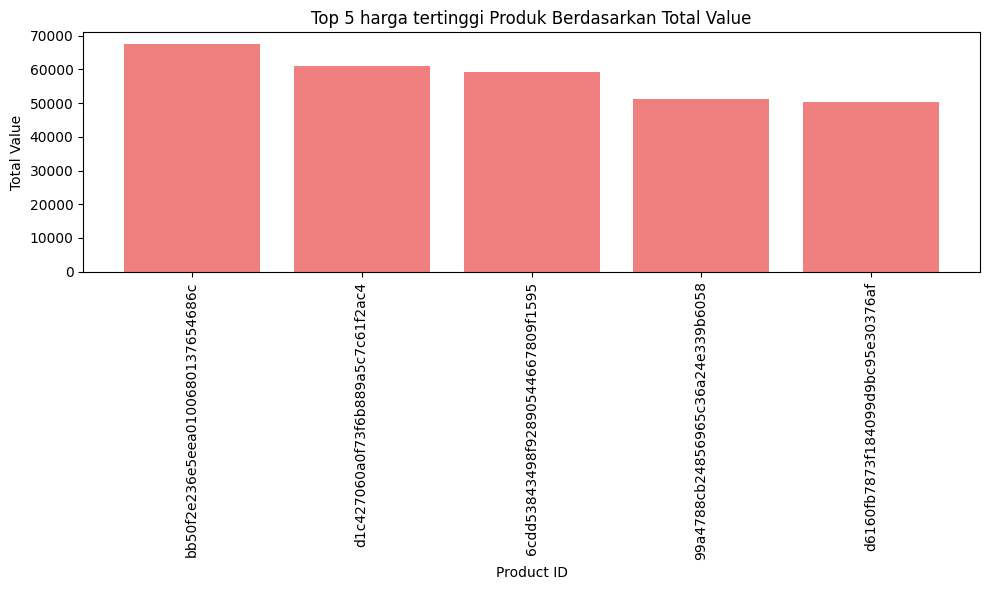

In [ ]:

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(top_5_total_value.index, top_5_total_value.values, color='lightcoral')
plt.title('Top 5 harga tertinggi Produk Berdasarkan Total Value')
plt.xlabel('Product ID')
plt.ylabel('Total Value')

# Rotasi label x-axis agar tidak tabrakan, secara vertikal
plt.xticks(rotation=90)

# Menata layout agar grafik tidak terpotong
plt.tight_layout()
plt.show()

**Melihat  sampel data Produk **

In [ ]:

print("\nProducts DataFrame")
products_df.head(n=10)


Products DataFrame


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
5,41d3672d4792049fa1779bb35283ed13,instrumentos_musicais,60.0,745.0,1.0,200.0,38.0,5.0,11.0
6,732bd381ad09e530fe0a5f457d81becb,cool_stuff,56.0,1272.0,4.0,18350.0,70.0,24.0,44.0
7,2548af3e6e77a690cf3eb6368e9ab61e,moveis_decoracao,56.0,184.0,2.0,900.0,40.0,8.0,40.0
8,37cc742be07708b53a98702e77a21a02,eletrodomesticos,57.0,163.0,1.0,400.0,27.0,13.0,17.0
9,8c92109888e8cdf9d66dc7e463025574,brinquedos,36.0,1156.0,1.0,600.0,17.0,10.0,12.0


Melihat informasi data awal,seperti jumlah baris,kolom dan jumlah nan

In [8]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


Berikut adalah penjelasan untuk setiap variabel dalam data ini:

1. **product_id**: ID unik yang mengidentifikasi produk di dalam sistem. Ini digunakan untuk membedakan produk yang satu dengan produk lainnya.

2. **product_category_name**: Nama kategori produk, misalnya "perfumaria" (kategori produk parfum). Ini mengelompokkan produk berdasarkan jenisnya.

3. **product_name_lenght**: Panjang nama produk dalam karakter. Ini memberikan informasi tentang panjang karakter dari nama produk yang tercatat dalam sistem.

4. **product_description_lenght**: Panjang deskripsi produk dalam karakter. Ini menunjukkan panjang karakter dari deskripsi yang menyertai produk, yang memberi informasi lebih lanjut mengenai produk tersebut.

5. **product_photos_qty**: Jumlah foto yang tersedia untuk produk tersebut. Ini memberi gambaran tentang seberapa banyak gambar yang diunggah oleh penjual untuk menggambarkan produk.

6. **product_weight_g**: Berat produk dalam gram. Ini menunjukkan seberapa berat produk tersebut, yang penting untuk perhitungan pengiriman.

7. **product_length_cm**: Panjang produk dalam sentimeter. Ini memberi ukuran dimensi panjang produk.

8. **product_height_cm**: Tinggi produk dalam sentimeter. Ini memberi ukuran dimensi tinggi produk.

9. **product_width_cm**: Lebar produk dalam sentimeter. Ini memberi ukuran dimensi lebar produk.



**menghapus fitur yang tidak di perlukan**

In [ ]:
products_df.drop(columns=['product_photos_qty','product_description_lenght','product_name_lenght'],inplace=True)


Melihat apakah ada data yang nan

In [ ]:
nan_counts = products_df.isna().sum()

# Menampilkan hasil
print(nan_counts)

product_id                 0
product_category_name    610
product_weight_g           2
product_length_cm          2
product_height_cm          2
product_width_cm           2
dtype: int64


**penghapusan data yang hilang**

In [ ]:
# Menghapus kolom yang seluruh isinya NaN
products_df_cleaned = products_df.dropna(axis=1, how='all')



**melihat kembali sampel data setelah di preprocesing**

In [ ]:
products_df_cleaned.head()

,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,625.0,20.0,17.0,13.0


**Proses penggabungan data**

bertujuan untuk menyatukan informasi dari berbagai sumber dalam satu DataFrame yang komprehensif. Dimulai dengan menghubungkan data pelanggan dan pesanan berdasarkan `customer_id`, memastikan semua pelanggan tetap tercatat meskipun tidak memiliki pesanan. Selanjutnya, data ulasan pesanan ditambahkan menggunakan `order_id` agar setiap pesanan yang memiliki ulasan dapat disertakan. Proses ini dilanjutkan dengan menggabungkan item pesanan berdasarkan `order_id`, sehingga setiap pesanan mencantumkan detail produk yang dipesan. Terakhir, informasi produk ditambahkan melalui `product_id` untuk melengkapi detail barang yang dibeli. Dengan metode **left join**, data utama seperti pelanggan dan pesanan tetap dipertahankan meskipun tidak semua pesanan memiliki ulasan, item, atau produk terkait. Hasil akhirnya adalah satu tabel yang mengintegrasikan seluruh informasi pelanggan, pesanan, ulasan, item pesanan, dan produk untuk analisis yang lebih mendalam.

In [ ]:
# Menggabungkan customers_df dan order_reviews_df berdasarkan customer_id dan order_id
merged_df = pd.merge(customers_df,orders_df, on='customer_id', how='left')
merged_df = pd.merge(merged_df, order_reviews_df, on='order_id', how='left')
merged_df = pd.merge(merged_df, order_items_df, on='order_id', how='left')
merged_df = pd.merge(merged_df, products_df, on='product_id', how='left')



**melihat data frame baru hasil pegabungan**

In [ ]:
merged_df.head()

,customer_id,customer_unique_id,customer_city,order_id,order_status,review_id,review_score,order_item_id,product_id,price,freight_value,total_value,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,00e7ee1b050b8499577073aeb2a297a1,delivered,88b8b52d46df026a9d1ad2136a59b30b,4.0,1.0,a9516a079e37a9c9c36b9b78b10169e8,124.99,21.88,146.87,moveis_escritorio,8683.0,54.0,64.0,31.0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,sao bernardo do campo,29150127e6685892b6eab3eec79f59c7,delivered,02fc48a9efa3e3d0f1a8ea26507eeec3,5.0,1.0,4aa6014eceb682077f9dc4bffebc05b0,289.00,46.48,335.48,utilidades_domesticas,10150.0,89.0,15.0,40.0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,sao paulo,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,5ad6695d76ee186dc473c42706984d87,5.0,1.0,bd07b66896d6f1494f5b86251848ced7,139.94,17.79,157.73,moveis_escritorio,8267.0,52.0,52.0,17.0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,mogi das cruzes,951670f92359f4fe4a63112aa7306eba,delivered,059a801bb31f6aab2266e672cab87bc5,5.0,1.0,a5647c44af977b148e0a3a4751a09e2e,149.94,23.36,173.30,moveis_escritorio,12160.0,56.0,51.0,28.0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,campinas,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,8490879d58d6c5d7773f2739a03f089a,5.0,1.0,9391a573abe00141c56e38d84d7d5b3b,230.00,22.25,252.25,casa_conforto,5200.0,45.0,15.0,35.0


Berikut adalah penjelasan mengenai masing-masing variabel dalam data ini:

1. **customer_id**: ID unik untuk masing-masing pelanggan. Ini digunakan untuk mengidentifikasi pelanggan dalam sistem.

2. **customer_unique_id**: ID pelanggan yang lebih permanen dan unik di seluruh sistem, yang memungkinkan identifikasi pelanggan meskipun mereka melakukan pembelian dengan beberapa akun.

3. **customer_city**: Kota tempat tinggal pelanggan, yang memberikan informasi mengenai lokasi geografis pelanggan.

4. **order_id**: ID unik untuk setiap pesanan. Ini digunakan untuk mengidentifikasi pesanan tertentu dalam sistem.

5. **order_status**: Status pesanan, misalnya "delivered", yang menunjukkan apakah pesanan telah berhasil dikirimkan dan diterima oleh pelanggan.

6. **review_id**: ID unik untuk setiap ulasan yang diberikan oleh pelanggan. Ini digunakan untuk mengidentifikasi ulasan yang terkait dengan produk atau pesanan.

7. **review_score**: Skor ulasan yang diberikan oleh pelanggan untuk produk tersebut, biasanya dalam skala 1-5. Ini memberi gambaran tentang kepuasan pelanggan terhadap produk yang dibeli.

8. **order_item_id**: ID unik untuk setiap item yang dipesan dalam satu pesanan. Ini digunakan untuk mengidentifikasi item spesifik dalam pesanan yang lebih besar.

9. **product_id**: ID unik untuk produk yang dipesan. Ini mengidentifikasi produk tertentu yang dibeli oleh pelanggan.

10. **price**: Harga produk sebelum biaya pengiriman. Ini memberikan informasi mengenai harga produk yang dipesan.

11. **freight_value**: Biaya pengiriman yang dikenakan untuk pesanan produk. Ini adalah biaya yang dibebankan kepada pelanggan untuk pengiriman barang.

12. **total_value**: Total nilai pesanan, yang merupakan jumlah dari harga produk dan biaya pengiriman. Ini menunjukkan biaya total yang dibayar pelanggan untuk produk dan pengiriman.

13. **product_category_name**: Nama kategori produk, seperti "moveis_escritorio" (furniture kantor) atau "utilidades_domesticas" (peralatan rumah tangga). Ini mengelompokkan produk berdasarkan jenisnya.

14. **product_weight_g**: Berat produk dalam gram. Ini menunjukkan berat produk yang dipesan.

15. **product_length_cm**: Panjang produk dalam sentimeter. Ini menunjukkan dimensi panjang produk.

16. **product_height_cm**: Tinggi produk dalam sentimeter. Ini menunjukkan dimensi tinggi produk.

17. **product_width_cm**: Lebar produk dalam sentimeter. Ini menunjukkan dimensi lebar produk.


**Melihat Kembali tipe data dan apakah ada yang null di dalam datased merged**

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114092 entries, 0 to 114091
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   customer_id            114092 non-null  object 
 1   customer_unique_id     114092 non-null  object 
 2   customer_city          114092 non-null  object 
 3   order_id               114092 non-null  object 
 4   order_status           114092 non-null  object 
 5   review_id              113131 non-null  object 
 6   review_score           113131 non-null  float64
 7   order_item_id          113314 non-null  float64
 8   product_id             113314 non-null  object 
 9   price                  113314 non-null  float64
 10  freight_value          113314 non-null  float64
 11  total_value            113314 non-null  float64
 12  product_category_name  111702 non-null  object 
 13  product_weight_g       113296 non-null  float64
 14  product_length_cm      113296 non-nu

**Menghapus seluruh data yang null atau hilang**

In [ ]:
merged_df_cleaned = merged_df.dropna()

**Melihat kembali apakah ada data yang hilang atau tidal**

In [ ]:
merged_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110773 entries, 0 to 114091
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   customer_id            110773 non-null  object 
 1   customer_unique_id     110773 non-null  object 
 2   customer_city          110773 non-null  object 
 3   order_id               110773 non-null  object 
 4   order_status           110773 non-null  object 
 5   review_id              110773 non-null  object 
 6   review_score           110773 non-null  float64
 7   order_item_id          110773 non-null  float64
 8   product_id             110773 non-null  object 
 9   price                  110773 non-null  float64
 10  freight_value          110773 non-null  float64
 11  total_value            110773 non-null  float64
 12  product_category_name  110773 non-null  object 
 13  product_weight_g       110773 non-null  float64
 14  product_length_cm      110773 non-null  f

**Melihat Sampel data yang sudah di preprocesing**

In [ ]:
merged_df_cleaned.head()

,customer_id,customer_unique_id,customer_city,order_id,order_status,review_id,review_score,order_item_id,product_id,price,freight_value,total_value,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,00e7ee1b050b8499577073aeb2a297a1,delivered,88b8b52d46df026a9d1ad2136a59b30b,4.0,1.0,a9516a079e37a9c9c36b9b78b10169e8,124.99,21.88,146.87,moveis_escritorio,8683.0,54.0,64.0,31.0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,sao bernardo do campo,29150127e6685892b6eab3eec79f59c7,delivered,02fc48a9efa3e3d0f1a8ea26507eeec3,5.0,1.0,4aa6014eceb682077f9dc4bffebc05b0,289.00,46.48,335.48,utilidades_domesticas,10150.0,89.0,15.0,40.0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,sao paulo,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,5ad6695d76ee186dc473c42706984d87,5.0,1.0,bd07b66896d6f1494f5b86251848ced7,139.94,17.79,157.73,moveis_escritorio,8267.0,52.0,52.0,17.0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,mogi das cruzes,951670f92359f4fe4a63112aa7306eba,delivered,059a801bb31f6aab2266e672cab87bc5,5.0,1.0,a5647c44af977b148e0a3a4751a09e2e,149.94,23.36,173.30,moveis_escritorio,12160.0,56.0,51.0,28.0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,campinas,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,8490879d58d6c5d7773f2739a03f089a,5.0,1.0,9391a573abe00141c56e38d84d7d5b3b,230.00,22.25,252.25,casa_conforto,5200.0,45.0,15.0,35.0


**Memastikan bahwa customer_id unik dan jika duplikat akan di hapus**

In [ ]:
# Menghitung jumlah kemunculan 'customer_id'
customer_counts = merged_df_cleaned['customer_id'].value_counts()

# Ambil hanya customer_id yang muncul lebih dari sekali
duplicates = customer_counts[customer_counts > 1]


# Menghapus duplikat, hanya mempertahankan satu entri per 'customer_id'
# Bisa memilih yang pertama atau yang terakhir berdasarkan kebutuhan
merged_df_cleaned_no_duplicates = merged_df_cleaned.drop_duplicates(subset='customer_id', keep='first')



In [ ]:
customer_counts = merged_df_cleaned_no_duplicates['customer_id'].value_counts()

# Ambil hanya customer_id yang muncul lebih dari sekali
duplicates = customer_counts[customer_counts > 1]

# Menampilkan 'customer_id' yang duplikat
print(duplicates)

Series([], Name: count, dtype: int64)


**Kembali melihat sampel data dari preprocesing**

In [ ]:
 merged_df_cleaned_no_duplicates.head()

,customer_id,customer_unique_id,customer_city,order_id,order_status,review_id,review_score,order_item_id,product_id,price,freight_value,total_value,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,00e7ee1b050b8499577073aeb2a297a1,delivered,88b8b52d46df026a9d1ad2136a59b30b,4.0,1.0,a9516a079e37a9c9c36b9b78b10169e8,124.99,21.88,146.87,moveis_escritorio,8683.0,54.0,64.0,31.0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,sao bernardo do campo,29150127e6685892b6eab3eec79f59c7,delivered,02fc48a9efa3e3d0f1a8ea26507eeec3,5.0,1.0,4aa6014eceb682077f9dc4bffebc05b0,289.00,46.48,335.48,utilidades_domesticas,10150.0,89.0,15.0,40.0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,sao paulo,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,5ad6695d76ee186dc473c42706984d87,5.0,1.0,bd07b66896d6f1494f5b86251848ced7,139.94,17.79,157.73,moveis_escritorio,8267.0,52.0,52.0,17.0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,mogi das cruzes,951670f92359f4fe4a63112aa7306eba,delivered,059a801bb31f6aab2266e672cab87bc5,5.0,1.0,a5647c44af977b148e0a3a4751a09e2e,149.94,23.36,173.30,moveis_escritorio,12160.0,56.0,51.0,28.0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,campinas,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,8490879d58d6c5d7773f2739a03f089a,5.0,1.0,9391a573abe00141c56e38d84d7d5b3b,230.00,22.25,252.25,casa_conforto,5200.0,45.0,15.0,35.0


**Melihat di mensi data yang akan di gunakana**

In [ ]:
 merged_df_cleaned_no_duplicates.shape

(96537, 17)

**Melihat top 5 Produk bedasrkan rata rata review score**

In [ ]:
top_5_review_scores_df =  merged_df_cleaned_no_duplicates.groupby('product_category_name')['review_score'].mean().nlargest(5).reset_index()
print(top_5_review_scores_df)


                product_category_name  review_score
0                   cds_dvds_musicais      4.666667
1                          la_cuisine      4.545455
2       fashion_roupa_infanto_juvenil      4.500000
3              livros_interesse_geral      4.467327
4  construcao_ferramentas_ferramentas      4.425532


Proses ini bertujuan untuk membangun representasi fitur produk guna menghitung kesamaan antar produk berdasarkan kategori dan atribut fisiknya. Pertama, diambil 20.000 sampel data dari `merged_df_cleaned_no_duplicates` untuk memastikan efisiensi dalam pemrosesan. Fitur yang digunakan meliputi kategori produk (`product_category_name`) sebagai data kategorikal serta atribut berat dan dimensi sebagai data numerik. Untuk mengolah kategori produk, digunakan metode **TF-IDF (Term Frequency-Inverse Document Frequency)** guna mengubah teks menjadi representasi numerik yang mencerminkan pentingnya suatu kategori dalam dataset. Sementara itu, fitur numerik seperti berat dan dimensi dinormalisasi menggunakan **StandardScaler** agar memiliki distribusi yang sebanding. Hasil representasi kategori dan fitur numerik kemudian digabungkan untuk membentuk satu matriks fitur yang lengkap. Langkah terakhir adalah menghitung **cosine similarity**, yaitu ukuran kesamaan antara produk berdasarkan fitur yang telah diproses, sehingga dapat digunakan untuk analisis keterkaitan atau rekomendasi produk.

In [ ]:


# Mengambil hanya 100 sampel data dari merged_df_cleaned_no_duplicates
sample_data = merged_df_cleaned_no_duplicates.sample(n=20000, random_state=42)

# Fitur yang akan digunakan
categories = sample_data['product_category_name']
numeric_features = ['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']

# Menggunakan TF-IDF untuk fitur kategorikal (product_category_name)
tfidf = TfidfVectorizer(stop_words='english')
category_tfidf = tfidf.fit_transform(categories)

# Normalisasi fitur numerik menggunakan StandardScaler
scaler = StandardScaler()
numeric_data = scaler.fit_transform(sample_data[numeric_features])

# Gabungkan hasil TF-IDF dan fitur numerik
features_combined = hstack([category_tfidf, numeric_data])

# Menghitung cosine similarity antar produk
cos_sim = cosine_similarity(features_combined)




 proses untuk mengevaluasi kinerja sistem rekomendasi produk dengan mengukur Precision, Recal berdasarkan kemiripan produk. PrecisionK menghitung persentase produk yang direkomendasikan dalam K produk teratas yang benar-benar relevan, sementara Recall@K mengukur seberapa banyak produk relevan yang berhasil ditemukan dari total produk relevan yang tersedia. Proses evaluasi dimulai dengan menghitung kesamaan antar produk menggunakan cosine similarity, lalu untuk setiap produk, dipilih K produk dengan skor kesamaan tertinggi sebagai rekomendasi. Precision dan Recall dihitung dengan membandingkan produk yang direkomendasikan dengan produk yang seharusnya relevan. Selanjutnya, MAP@K digunakan untuk menilai kualitas rekomendasi secara keseluruhan dengan menghitung rata-rata presisi pada berbagai posisi dalam daftar peringkat. Hasil akhirnya adalah metrik evaluasi yang memberikan gambaran seberapa akurat sistem dalam merekomendasikan produk kepada pengguna.

In [ ]:


# Fungsi untuk menghitung Precision dan Recall pada K produk teratas
def precision_recall_at_k(cos_sim, df, top_n=3):
    precision_list = []
    recall_list = []

    # Menghitung Precision dan Recall untuk setiap produk
    for idx in range(len(df)):
        # Mengambil skor kesamaan produk terhadap produk lainnya
        sim_scores = list(enumerate(cos_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Mengambil K produk teratas
        top_k_indices = [i[0] for i in sim_scores[1:top_n+1]]

        # Menghitung Precision dan Recall
        relevant_items = set(top_k_indices)  # Produk relevan yang telah dipilih
        retrieved_items = set(top_k_indices)  # Produk yang telah direkomendasikan

        precision = len(retrieved_items & relevant_items) / len(retrieved_items) if len(retrieved_items) > 0 else 0
        recall = len(retrieved_items & relevant_items) / len(relevant_items) if len(relevant_items) > 0 else 0

        precision_list.append(precision)
        recall_list.append(recall)

    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)

    return avg_precision, avg_recall

# Fungsi untuk menghitung MAP@K
def mean_average_precision_at_k(cos_sim, df, top_n=3):
    avg_precision_list = []

    for idx in range(len(df)):
        sim_scores = list(enumerate(cos_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        top_k_indices = [i[0] for i in sim_scores[1:top_n+1]]

        # Asumsikan produk relevan yang dipilih memiliki relevansi 1
        # relevansi dapat berupa 1 untuk relevan, 0 untuk tidak relevan
        relevances = [1 if i in top_k_indices else 0 for i in range(len(df))]

        # Menggunakan skor kesamaan sebagai prediksi untuk menghitung rata-rata presisi
        relevance_scores = [x[1] for x in sim_scores[1:top_n+1]]

        try:
            avg_precision = average_precision_score(relevances, relevance_scores)
            avg_precision_list.append(avg_precision)
        except ValueError:
            # Jika terjadi error karena tidak ada variasi dalam relevansi
            continue

    return np.mean(avg_precision_list) if avg_precision_list else 0

# Evaluasi Precision@K, Recall@K dan MAP@K
top_n = 3  # Mengambil 3 produk teratas
precision, recall = precision_recall_at_k(cos_sim, sample_data, top_n)
map_k = mean_average_precision_at_k(cos_sim, sample_data, top_n)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Precision: 1.0000
Recall: 1.0000


proses ini untuk merekomendasikan produk berdasarkan kategori yang dipilih dengan memanfaatkan cosine similarity antara produk. Proses dimulai dengan mencari semua produk dalam dataset yang memiliki kategori yang sesuai. Jika tidak ada produk dalam kategori tersebut, maka fungsi akan mengembalikan DataFrame kosong sebagai indikasi bahwa tidak ada produk yang bisa direkomendasikan. Selanjutnya, untuk setiap produk dalam kategori yang ditemukan, dihitung kesamaan dengan semua produk lain dalam dataset menggunakan matriks kesamaan (cos_sim). Setelah itu, produk diurutkan berdasarkan nilai kesamaan tertinggi, dan top-N produk teratas dipilih sebagai rekomendasi, dengan pengecualian produk itu sendiri agar tidak muncul dalam daftar rekomendasi. Hasil akhir dari fungsi ini adalah subset DataFrame yang berisi produk-produk yang paling mirip berdasarkan kategori dan fitur yang telah diproses sebelumnya.

In [ ]:
# Fungsi untuk merekomendasikan produk berdasarkan index produk
def recommend_by_category(category, cos_sim, df, top_n=3):
    # Menemukan semua produk yang memiliki kategori yang sama
    category_idx = df[df['product_category_name'] == category].index.tolist()

    # Memastikan kategori yang ditemukan memiliki produk dalam data sampel
    if not category_idx:
        print(f"Tidak ada produk dalam kategori {category}")
        return pd.DataFrame()  # Mengembalikan DataFrame kosong jika kategori tidak ditemukan

    # Mendapatkan nilai kesamaan dengan produk lainnya
    sim_scores = []
    for idx in category_idx:
        # Pastikan indeks ada dalam range ukuran data yang disampel
        if idx < cos_sim.shape[0]:
            sim_scores.extend(list(enumerate(cos_sim[idx])))

    # Mengurutkan produk berdasarkan skor kesamaan tertinggi
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Mengambil top_n produk rekomendasi
    sim_scores = sim_scores[1:top_n+1]  # Menghindari produk itu sendiri
    product_indices = [i[0] for i in sim_scores]
    return df.iloc[product_indices]


proses ini digunakan untuk mendapatkan rekomendasi produk berdasarkan kategori tertentu dengan memilih produk yang memiliki kemiripan tertinggi dalam kategori tersebut. Pertama, kategori yang dicari ditentukan (category_to_search = 'automotivo'). Kemudian, fungsi recommend_by_category dipanggil untuk mencari produk dalam kategori "automotivo" yang memiliki kesamaan fitur dengan produk lain berdasarkan cosine similarity (cos_sim). Hasil rekomendasi berupa 5 produk teratas dengan nilai kesamaan tertinggi yang akan disimpan dalam recommended_products. Terakhir, hasil rekomendasi ditampilkan dengan hanya menyertakan informasi kategori, berat, panjang, tinggi, dan lebar produk, sehingga pengguna dapat melihat perbandingan fitur dari produk yang direkomendasikan.

In [ ]:
category_to_search = 'automotivo'  # Ganti dengan kategori yang diinginkan
recommended_products = recommend_by_category(category_to_search, cos_sim, sample_data, top_n=5)
print(recommended_products[['product_category_name', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']])


      product_category_name  product_weight_g  product_length_cm  \
63674       cama_mesa_banho             750.0               40.0   
16392       cama_mesa_banho             750.0               40.0   
47008       cama_mesa_banho             750.0               40.0   
68014            brinquedos            1133.0               33.0   
61814          beleza_saude             333.0               17.0   

       product_height_cm  product_width_cm  
63674                4.0              30.0  
16392                4.0              30.0  
47008                4.0              30.0  
68014               23.0              21.0  
61814               17.0              15.0  


**mengcopy data ke data frame baru yang bertujuan untuk melakukan exprimen untuk membagun model**

In [ ]:
reza= sample_data.copy()

proses ini membangun model **rekomendasi berbasis faktor tersembunyi (latent factor model)** menggunakan **Neural Collaborative Filtering (NCF)** untuk memprediksi **review score** berdasarkan pelanggan dan kategori produk.  

**Tahapan utama dalam kode:**  
1. **Preprocessing Data** – Fitur numerik seperti harga (`price`), ongkos kirim (`freight_value`), dan total (`total_value`) disiapkan. Label target adalah `review_score`, sedangkan pelanggan (`customer_unique_id`) dan produk (`product_category_name`) dikodekan menjadi nilai numerik.  
2. **Normalisasi & Split Data** – `review_score` dinormalisasi menggunakan `MinMaxScaler()`, lalu data dibagi menjadi **80% data latih dan 20% data uji**.  
3. **Arsitektur Model** – Model dibuat menggunakan dua **embedding layer** untuk pelanggan dan produk, yang kemudian dikombinasikan dengan operasi **dot product** untuk menangkap hubungan antar entitas. Hasilnya kemudian diratakan (`Flatten()`) untuk menghasilkan skor prediksi.  
4. **Pelatihan Model** – Model dikompilasi dengan **Adam optimizer** dan **Huber loss**, serta dilatih dengan teknik **early stopping** untuk mencegah overfitting.  
5. **Evaluasi Model** – Model diuji menggunakan **Mean Absolute Error (MAE)** untuk mengukur performanya.  
6. **Cosine Similarity** – Setelah pelatihan, embedding yang telah dipelajari dianalisis dengan **cosine similarity**, baik untuk pelanggan maupun produk, guna memahami pola kesamaan dalam representasi vektor.  

Hasil dari model ini dapat digunakan untuk memberikan rekomendasi produk yang lebih personal kepada pelanggan berdasarkan pola ulasan mereka sebelumnya.

In [ ]:


# Data Preprocessing
features = ['price', 'freight_value', 'total_value']
y = reza['review_score']
customers = reza['customer_unique_id']
products = reza['product_category_name']

# Encode categorical features
customers_encoded = customers.factorize()[0]
products_encoded = products.factorize()[0]

# Scale review scores
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Train-test split
customers_train, customers_test, products_train, products_test, y_train, y_test = train_test_split(
    customers_encoded, products_encoded, y_scaled, test_size=0.2, random_state=42
)

# Define model
embedding_dim = 150

# Inputs
user_input = Input(shape=(1,), name='user_input', dtype='int32')
product_input = Input(shape=(1,), name='product_input', dtype='int32')

# Embedding layers
user_embedding = Embedding(input_dim=len(customers.unique()) + 1, output_dim=embedding_dim, name="user_embedding")(user_input)
product_embedding = Embedding(input_dim=len(products.unique()) + 1, output_dim=embedding_dim, name="product_embedding")(product_input)

# Dot product
dot_product = Dot(axes=-1, normalize=False)([user_embedding, product_embedding])

# Flatten output
output = Flatten()(dot_product)

# Compile model
model = Model(inputs=[user_input, product_input], outputs=output)
model.compile(optimizer=Adam(), loss=Huber(), metrics=['mae'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(
    [customers_train, products_train],
    y_train,
    validation_data=([customers_test, products_test], y_test),
    epochs=10,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

# Evaluate model
loss, mae = model.evaluate([customers_test, products_test], y_test)
print(f"\nTest Loss: {loss:.4f}, Test MAE: {mae:.4f}")

# Optional: Print Cosine Similarity for the first few customers and products
user_embedding_matrix = model.get_layer("user_embedding").get_weights()[0]
product_embedding_matrix = model.get_layer("product_embedding").get_weights()[0]

user_similarity = cosine_similarity(user_embedding_matrix[:10])  # Check for first 10 users
product_similarity = cosine_similarity(product_embedding_matrix[:10])  # Check for first 10 products

print("\nUser Similarity Matrix (Top 10):")
print(user_similarity)

print("\nProduct Similarity Matrix (Top 10):")
print(product_similarity)


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - loss: 0.3548 - mae: 0.7749 - val_loss: 0.3546 - val_mae: 0.7730
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.2474 - mae: 0.6391 - val_loss: 0.3543 - val_mae: 0.7750
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0414 - mae: 0.2328 - val_loss: 0.3534 - val_mae: 0.7733
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - loss: 0.0180 - mae: 0.1492 - val_loss: 0.3535 - val_mae: 0.7731
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0105 - mae: 0.1148 - val_loss: 0.3533 - val_mae: 0.7729
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0093 - mae: 0.1097 - val_loss: 0.3533 - val_mae: 0.7728
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0099 - mae: 0.1174 - val_loss: 0.3533 - val_mae: 0.7727
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: 0.0113 - mae: 0.1296 - val_loss: 0.3532 - val_mae: 0.7727
Epoch 9/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 11

**Melakukan rekomendasi terhadap id user dengan cara**

1. **Menentukan `user_id`**: Menentukan ID pengguna yang ingin diberikan rekomendasi produk.
2. **Mencari `user_idx`**: Menemukan posisi pengguna dalam dataset berdasarkan `user_id`.
3. **Input untuk Model**: Membuat input untuk model dengan memasukkan ID pengguna dan ID produk.
4. **Prediksi**: Model menghitung skor relevansi antara pengguna dan produk.
5. **Top Produk**: Mengambil produk dengan skor tertinggi berdasarkan prediksi.
6. **Tampilkan Rekomendasi**: Menampilkan produk yang direkomendasikan dengan kategori asli.

Kode ini memberikan **5 produk teratas** yang direkomendasikan berdasarkan skor prediksi dari model.

In [ ]:


# Misalkan user_id adalah string yang ingin direkomendasikan
user_id = '12d43aa0d63d45af21a491244b44e73e'  # Ganti dengan ID pengguna yang diinginkan

user_idx = np.where(customers_encoded == customers.factorize()[0])[0][0]

# Produk yang sudah di-encode
unique_products = np.unique(products_encoded)  # Perbaikan di sini

# Membuat pasangan ID produk untuk setiap user_id tertentu
user_input_data = np.full((len(unique_products), 1), user_idx)  # Input ID user
product_input_data = unique_products.reshape(-1, 1)  # Input produk untuk semua produk yang unik

# Prediksi skor untuk semua produk
predicted_scores = model.predict([user_input_data, product_input_data])

# Menemukan produk dengan skor tertinggi
top_product_indices = np.argsort(predicted_scores.flatten())[::-1][:5]  # Ambil 5 produk teratas

# Menampilkan produk yang direkomendasikan (kembali ke format kategori asli)
recommended_products = products.iloc[top_product_indices]

# Pastikan tidak ada produk yang berulang
recommended_products_unique = recommended_products.drop_duplicates()

print(f"Rekomendasi untuk user ID {user_id} adalah produk-produk berikut:")
print(recommended_products_unique)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Rekomendasi untuk user ID 12d43aa0d63d45af21a491244b44e73e adalah produk-produk berikut:
46009                     brinquedos
3329                 eletroportateis
31096    fashion_bolsas_e_acessorios
88136             ferramentas_jardim
Name: product_category_name, dtype: object
